### Analyse de texte et traitement du langage naturel
Sonic 2
#### importation bibliothèques

In [15]:
import requests
import lxml.html as lh
import pandas as pd
import csv
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
# scraping
url = 'https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/'
uri_pages = '?page='
nbPages = 400
tags = ['//span[@class="stareval-note"]', \
        '//div[@class="content-txt review-card-content"]' ]
cols = ['Note', 'Description' ]
 
page = requests.get(url)
doc = lh.fromstring(page.content)

In [17]:
# definition
def getPage(url):
    page = requests.get(url)
    doc = lh.fromstring(page.content)
 
    # Get the Web data via XPath
    content = []
    for i in range(len(tags)):
        content.append(doc.xpath(tags[i]))
 
    # Gather the data into a Pandas DataFrame array
    df_liste = []
    for j in range(len(tags)):
        tmp = pd.DataFrame([content[j][i].text_content().strip() for i in range(len(content[i]))], columns=[cols[j]])
        tmp['key'] = tmp.index
        df_liste.append(tmp)
 
    # Build the unique Dataframe with one tag (xpath) content per column
    liste = df_liste[0]
    for j in range(len(tags)-1):
        liste = liste.join(df_liste[j+1], on='key', how='left', lsuffix='_l', rsuffix='_r')
        liste['key'] = liste.index
        del liste['key_l']
        del liste['key_r']
     
    return liste

#### Pagination

In [18]:
def getPages(_nbPages, _url):
    liste_finale = pd.DataFrame()
    for i in range (_nbPages):
        liste = getPage(_url + uri_pages + str(i+1))
        liste_finale = pd.concat([liste_finale, liste], ignore_index=True)
    return liste_finale
 
liste_totale = getPages(nbPages, url)

### création csv

In [19]:
liste_totale = getPages(nbPages, url)
liste_totale.to_csv('allocine_sonic2.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [20]:
pd.read_csv('allocine_sonic2.csv')

,Note,Description,key
0,"5,0",Cette suite de sonic est incroyable !Le fan qu...,0
1,"4,0",une bonne suite pour les aventures de sonic au...,1
2,"3,0",Malgré deux nouveaux personnages de l'univers ...,2
3,"4,0",Très bon film ont retrouve ce qui fait l’espri...,3
4,"4,0","Super film de ouf, le fait que Knuckles soit d...",4
...,...,...,...
4040,"5,0",J'ai adoré ce film beaucoup mieux que le premi...,5
4041,"5,0",Le film est trop bien la qualité du film est s...,6
4042,"4,0",Excellent film à voir petit comme grand. J’ai ...,7
4043,"5,0","Vraiment pas mal, ils respectent bien les pers...",8


### Etape 2 : Préparation des données

#### Retirer les bruits des commentaires
#### utiliser les expressions régulières

In [21]:
REMPLACE_SANS_ESPACE = re.compile("[;:!\'?,\"()\[\]]")
REMPLACE_AVEC_ESPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|[.]")

def preprocess(txt):
    txt = [line.replace('\n', ' ')  for line in txt] # Retire les \n (retours chariots)
    txt = [REMPLACE_SANS_ESPACE.sub("", line.lower()) for line in txt]
    txt = [REMPLACE_AVEC_ESPACE.sub(" ", line) for line in txt]
    return txt

#### Simplification des données de commentaires

In [22]:
X = pd.read_csv('./allocine_sonic2.csv')

X['Description'] = pd.DataFrame(preprocess(X['Description']))
french_stopwords = set(stopwords.words('french'))
filtre_stopfr =  lambda text: [token for token in text if token.lower() not in french_stopwords]
X['Description'] = [' '.join(filtre_stopfr(word_tokenize(item))) for item in X['Description']]

stemmer = FrenchStemmer()
X['Description'] = [stemmer.stem(w) for w in X['Description']]

#### affichage des mots inutiles (stopwords)

In [23]:
print(french_stopwords)

{'mes', 'fût', 'nos', 'dans', 'eussions', 'des', 'on', 'm', 's', 'sera', 'serez', 'serait', 'aurez', 'eût', 'serais', 'auriez', 'fûmes', 'furent', 'ayants', 'ou', 'avais', 'étante', 'auraient', 'n', 'de', 'la', 'sont', 'qu', 'aient', 'eussiez', 'j', 'mon', 'du', 'avez', 'ont', 'sur', 'étions', 'sois', 'elle', 'suis', 'étiez', 'tu', 'eu', 'as', 'ses', 'auras', 'auront', 'fûtes', 'eûtes', 'aurait', 'aurai', 'aie', 'était', 't', 'ta', 'soient', 'pas', 'son', 'mais', 'serai', 'soyons', 'eue', 'eussent', 'fus', 'sommes', 'c', 'pour', 'd', 'seront', 'étantes', 'ma', 'notre', 'fusses', 'étés', 'qui', 'tes', 'ai', 'ayons', 'seriez', 'aux', 'eusse', 'aurais', 'se', 'ayant', 'serions', 'votre', 'ils', 'étée', 'fut', 'vos', 'vous', 'seraient', 'leur', 'les', 'serons', 'à', 'fussiez', 'que', 'eûmes', 'est', 'ne', 'l', 'fussions', 'aurions', 'seras', 'eurent', 'ayez', 'avaient', 'lui', 'es', 'avait', 'aies', 'eues', 'soit', 'fusse', 'ces', 'eus', 'sa', 'étant', 'ton', 'eux', 'avec', 'moi', 'étais',

In [24]:
for ok in X:
    print (ok)
    
X=X.drop('key',axis=1)
print("=======================")

for ok in X:
    print (ok)

Note
Description
key
Note
Description


### Etape 3: Préparation des libellés

In [25]:
def setClassBin(i):
    if (float(i.replace(',', '.')) > 3):
        return 1
    else:
        return 0
 
yList = [setClassBin(x) for x in X.Note]
y = pd.DataFrame(yList, columns=['classe'])
#X = X.drop('Note', axis=1)

In [26]:
print("Composition de X: \n")
for k in X:
    print(k)

print("====================================================")

print("Composition de y: \n")
for kk in y:
    print(kk)

print("====================================================")

print("Contenue de y[classe]: \n")
for kkk in y['classe']:
    print(kkk)

Composition de X: 

Note
Description
Composition de y: 

classe
Contenue de y[classe]: 

1
1
0
1
1
1
0
1
0
0
1
0
0
0
0
1
1
1
0
1
0
0
0
0
1
0
0
1
1
1
1
1
0
0
0
1
0
1
1
1
1
1
0
0
0
0
1
0
1
0
0
0
0
0
0
1
1
1
1
1
0
1
0
0
0
1
1
1
0
1
1
1
0
1
0
1
0
0
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
0
1
1
0
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1

In [27]:
print("Shape de y: ", y.shape)
print("Shape de X: ", X.shape)

Shape de y:  (4045, 1)
Shape de X:  (4045, 2)


In [28]:
print("Labels dans X: \n")
for a in X:
    print(a)
print("========================")
print("Labels dans y: \n")
for b in y:
    print(b)

Labels dans X: 

Note
Description
Labels dans y: 

classe


### Etape 4 : Finalisation du jeu de données

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X['Description'], y['classe'], test_size=0.2)

In [30]:
#for i in X_train:
#    print(i)

#print(type(X_train["Description"]))

In [31]:
for j in y_train:
    print(j)

1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
0
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
0
0
1
0
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
0
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
0
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1


In [32]:
#Vérifier le contenue car bug avec les espaces
#mis en com car trop de texte

#for op in X['Description']:
#    print (op)

#### Vectorisation des mots (sac de mots)

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

Vectorizer = CountVectorizer(binary=True)
Vectorizer.fit(X_train)
 
X_train_vectorized = Vectorizer.transform(X_train)
X_test_vectorized = Vectorizer.transform(X_test)
pd.DataFrame(X_train_vectorized.toarray())

,0,1,2,3,4,5,6,7,8,9,...,2440,2441,2442,2443,2444,2445,2446,2447,2448,2449
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Etape 5 : Entrainement du modèle

- hyperparamètre __c__ 
    - Objectif : trouver le meilleur

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


for c in [0.01, 0.05, 0.25, 0.5, 1]:
    logisRegre = LogisticRegression(C=c)
    logisRegre.fit(X_train_vectorized, y_train)
    print ("Précision pour C=%s: %s" % (c, accuracy_score(y_test, logisRegre.predict(X_test_vectorized))))
    



pred=logisRegre.predict(X_test_vectorized[1])
print(pred, y_test[1])

Précision pour C=0.01: 0.9888751545117429
Précision pour C=0.05: 0.9901112484548825
Précision pour C=0.25: 0.9901112484548825
Précision pour C=0.5: 0.9888751545117429
Précision pour C=1: 0.9888751545117429


KeyError: 1

### Etape 6 : Analyse des résultats

- Entrainer le modèle à partir du paramètre c = 0.25

In [41]:
modele_final = LogisticRegression(C=1)
modele_final.fit(X_train_vectorized, y_train)


print ("Précision: %s" % accuracy_score(y_test, modele_final.predict(X_test_vectorized)))

Précision: 0.9888751545117429


<AxesSubplot:>

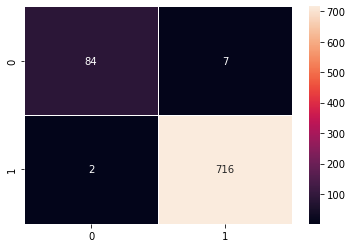

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = modele_final.predict(X_test_vectorized)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')